In [6]:
#this notebook is for the implementation of sampling based inference method in Gershman (2009)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from gershman_09_function import likelihood, MRF_prior, proposal_function, sample_rejection, state_count, domi_period_count

In [4]:
state_list_lamda0 = []
#define initial z
z = (np.random.rand(4,4)-0.5)*2
print(z)
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection(z,z_star,lamda=0)
    if acc:
        z = z_star
    state_list_lamda0.append(z)
    
state_list_lamda005 = []
#define initial z
z = (np.random.rand(4,4)-0.5)*2
print(z)
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection(z,z_star,lamda=0.05)
    if acc:
        z = z_star
    state_list_lamda005.append(z)
    
state_list_lamda010 = []
#define initial z
z = (np.random.rand(4,4)-0.5)*2
print(z)
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection(z,z_star,lamda=0.10)
    if acc:
        z = z_star
    state_list_lamda010.append(z)

[[ 0.62780343  0.73482448  0.90253891 -0.88028975]
 [ 0.20644518  0.263747   -0.08165489 -0.98243043]
 [ 0.71896374  0.23477674 -0.44299465  0.33321755]
 [-0.3072221  -0.54705948  0.92405125  0.57276927]]
[[ 0.4666734  -0.91053523 -0.06953609 -0.82544962]
 [-0.86392844  0.56175663 -0.51060801  0.02369605]
 [-0.78242784  0.87183073  0.70582764 -0.68918091]
 [-0.46033341  0.32443235 -0.60598763 -0.3827278 ]]
[[ 0.430673    0.53144862  0.78453178 -0.62358486]
 [-0.43989369 -0.29393123  0.95668126 -0.78831253]
 [ 0.52438489  0.94306823 -0.60493214  0.73449301]
 [ 0.72871498 -0.47294748 -0.28143046 -0.66393191]]


In [40]:
from scipy.optimize import curve_fit

def gamma(x,a,b,c):
    return c*np.exp(-b*x)*x**(a-1)

def gamma_fit_plot(state_list,n,n_cut=50):
    state_number = np.array([len(np.where(z_i>0)[0]) for z_i in state_list])
    domi_period = np.array(domi_period_count(state_number,dim = 4))
    domi_period = np.sort(domi_period)
    domi_period = domi_period[:-n_cut]
    y,bins=np.histogram(domi_period,n)
    x = []
    for i in range(1,int(n+1)):
        x.append((bins[i]+bins[i-1])/2)
    x=np.array(x)
    popt,pcov = curve_fit(gamma,x/1000,y)
    plt.plot(x/1000,gamma(x/1000,popt[0],popt[1],popt[2]))
    plt.hist(domi_period/1000,int(n+1))
    plt.xlabel('dominance duration')
    plt.ylabel('density')
    plt.legend(['fitted','histogram'])
    return popt

array([1.88295015e+00, 4.93579101e+00, 2.63089042e+03])

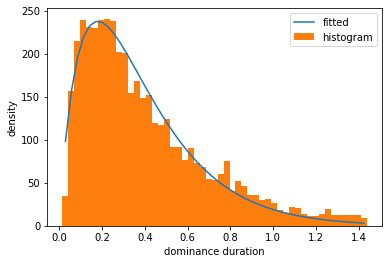

In [43]:
gamma_fit_plot(state_list_lamda0,50,100)

array([   1.71428135,    3.75351233, 1343.15365172])

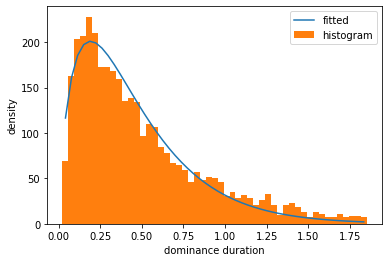

In [42]:
gamma_fit_plot(state_list_lamda005,50,100)

array([  1.32896957,   1.96239494, 228.56898816])

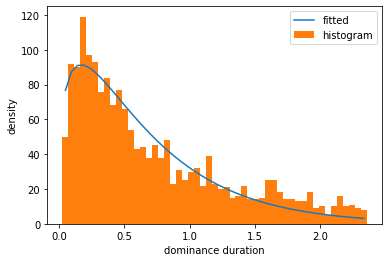

In [45]:
gamma_fit_plot(state_list_lamda010,50,200)

In [9]:
def likelihood_ring(z,a = 1,b = -1,sigma = 0.3):
    #bi-modal, mixture of Gaussian function
    #2 peaks at -1 and 1
    #return: a scalar, p(x|z) as a functino of z
    z_vec = z.reshape(-1)
    likelihood_ele = np.exp(-0.5/sigma**2*(z+a)**2)+np.exp(-0.5/sigma**2*(z+b)**2)
    return np.prod(likelihood_ele)

def MRF_prior_ring(z,lamda = 0.80,mu_array = np.array([0])):
    #return the Gaussian MRF of the perception
    #'reflection on boundary first
    dim = len(z)
    z_extended = np.hstack((z[-1],z,z[0]))
    sum_dis = 0
    for i in range(1,dim+1):
        sum_dis = sum_dis + (z_extended[i]-z_extended[i+1])**2 + (z_extended[i]-z_extended[i-1])**2
    return np.exp(-lamda*sum_dis)*np.prod(np.exp(mu_array))

def proposal_function_ring(z, sigma = 1.5):
    #generate a new proposal from the current sample
    #change only one element at a time!
    dim = z.shape[0]
    z_star = z.copy()
    i = random.randint(0,dim-1)
    z_star[i] = z_star[i] + sigma*np.random.normal()
    return z_star

def sample_rejection_ring(z,z_star):
    #input: z is the current sample
    #z_star is the proposed sample
    #if sample accepted: return True
    #if rejected: return False
    p_z = likelihood_ring(z)*MRF_prior_ring(z)
    p_z_star = likelihood_ring(z_star)*MRF_prior_ring(z_star)
    p_acc = min(1,p_z_star/p_z)
    if random.random()<p_acc:
        return True
    else:
        return False

In [16]:
state_list = []
state_list_count = []
#define initial z
z = (np.random.rand(50)-0.5)*2
print(z)
for i in range(int(2e6)):
    z_star = proposal_function_ring(z, sigma = 2)
    acc = sample_rejection_ring(z,z_star)
    if acc:
        z = z_star
    state_list.append(z)

[ 0.76920724 -0.29873976  0.03909452  0.60092152  0.91342409  0.03529524
  0.48678058  0.1802054  -0.60720192 -0.45344392 -0.84650452  0.26844241
 -0.22394027  0.41943608 -0.37281876 -0.03148944 -0.18390189 -0.95402931
 -0.36718816  0.88929056 -0.87147391 -0.58513461  0.22808126 -0.39355428
  0.97589182 -0.46662557 -0.91963282 -0.40775676 -0.1783706  -0.5644489
  0.89717483  0.54462885 -0.81649774  0.63752542  0.64739707 -0.09004701
  0.66299753  0.02308344  0.25728793 -0.29218401 -0.20541123  0.3188161
  0.85220212 -0.98942522 -0.51628836  0.79759506 -0.14345812 -0.17923167
 -0.03071915 -0.70172214]


In [11]:
import scipy.signal as sig
def corr(x,y,n):
    #x, y: arrays to calculate correlation
    #n: cover correlation rxy(0) to rxy(n-1)
    conv_xy=sig.convolve(np.flip(x),y)
    rxy=np.zeros(int(n))
    for i in range(n):
        rxyi=conv_xy[len(x)+i-1]
        #for j in range(min(len(y)-n,len(x))):
            #rxyi=rxyi+x[j]*y[j+i]
        rxyi=rxyi/min(len(y)-n,len(x))
        rxy[i]=rxyi
    return rxy

In [17]:
neuron_response = []
for i in range(50):
    neuron_response.append([s_i[i] for s_i in state_list])

corr_list = []
for j in range(1,50):
    corr_list.append(corr(neuron_response[0],neuron_response[j],500))


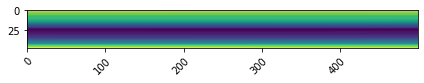

In [23]:
corr_array = np.array(corr_list)
fig, ax = plt.subplots()
im = ax.imshow(corr_array)

plt.show()

In [17]:
trans_time = []
for corr1 in corr_list:
    trans_time.append(np.argmax(corr1))
trans_time = np.array(trans_time)

Text(0.5, 1.0, 'travelling wave by correlation')

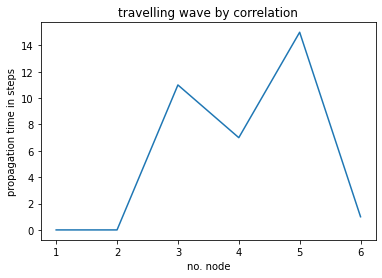

In [18]:
plt.plot(np.arange(1,7),trans_time)
plt.xlabel('no. node')
plt.ylabel('propagation time in steps')
plt.title('travelling wave by correlation')

In [19]:
switch_list = []
while len(switch_list)<100:
    z = np.hstack((np.array([1]),-np.ones(6)))
    switch_list_i = [-1,-1,-1,-1,-1,-1,-1]
    #define initial z
    for j in range(1000):
        z_star = proposal_function_ring(z, sigma = 2)
        acc = sample_rejection_ring(z,z_star)
        if acc:
            z = z_star
        for m in range(1,7):
            if z[m]>0 and switch_list_i[m] == -1:
                switch_list_i[m] = j
    if switch_list_i[1]>0 and switch_list_i[2]>0 and switch_list_i[3]>0 and switch_list_i[4]>0 and switch_list_i[5]>0 and switch_list_i[6]>0:
        switch_list.append(switch_list_i)

In [20]:
switch_list = np.array(switch_list)
pro_time = np.average(switch_list, axis=0)

Text(0.5, 1.0, 'travelling wave by averaged switching time')

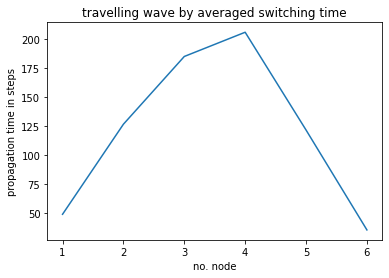

In [21]:
plt.plot(np.arange(1,7),pro_time[1:])
plt.xlabel('no. node')
plt.ylabel('propagation time in steps')
plt.title('travelling wave by averaged switching time')